# Naive Bayes Classifier on Mushroom Dataset

This notebook is applying Naive Bayes classification on the mushroom dataset.

**References:**

* For Naive Bayes Classifier implementation, [Naive Bayes Classification explained with Python code](http://www.datasciencecentral.com/profiles/blogs/naive-bayes-classification-explained-with-python-code) by Ahmet Taspinar.
* For data visualization, [Mushroom Classification - Edible or Poisonous?](https://github.com/paix120/DataScienceLearningClubActivities/blob/master/Activity05/Mushroom%20Edibility%20Classification%20-%20Naive%20Bayes.ipynb) by Renee Teate.
* For mushroom dataset, [Kaggle Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification).

In [27]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

%matplotlib inline

## 1 Data

### 1.1 Load data

In [35]:
data = pd.read_csv('../Datasets/mushrooms.csv')
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [36]:
print("Example values:\n")
print(data.iloc[3984]) #this one has a ? value - how are those treated by classifier?

Example values:

class                       e
cap-shape                   x
cap-surface                 y
cap-color                   b
bruises                     t
odor                        n
gill-attachment             f
gill-spacing                c
gill-size                   b
gill-color                  e
stalk-shape                 e
stalk-root                  ?
stalk-surface-above-ring    s
stalk-surface-below-ring    s
stalk-color-above-ring      e
stalk-color-below-ring      w
veil-type                   p
veil-color                  w
ring-number                 t
ring-type                   e
spore-print-color           w
population                  c
habitat                     w
Name: 3984, dtype: object


### 1.2 Analyze data

#### Edibile/poisonous distribution

e    4208
p    3916
Name: class, dtype: int64


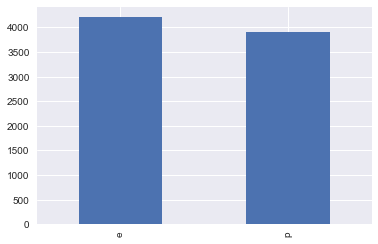

In [29]:
#bar chart of classes using pandas plotting
print(data['class'].value_counts())
data['class'].value_counts().plot(kind='bar')

#### Cap shape - edible or poisonous?

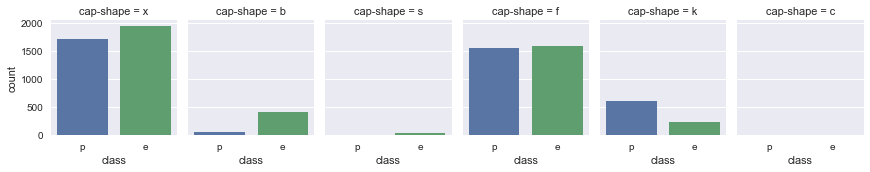

In [31]:
#seaborn factorplot to show edible/poisonous breakdown by different factors
df_forplot = data.loc[:,('class','cap-shape','gill-color')]
g = sns.factorplot("class", col="cap-shape", data=df_forplot,
                    kind="count", size=2.5, aspect=.8, col_wrap=6)

#### Gill color - edible or poisonous?

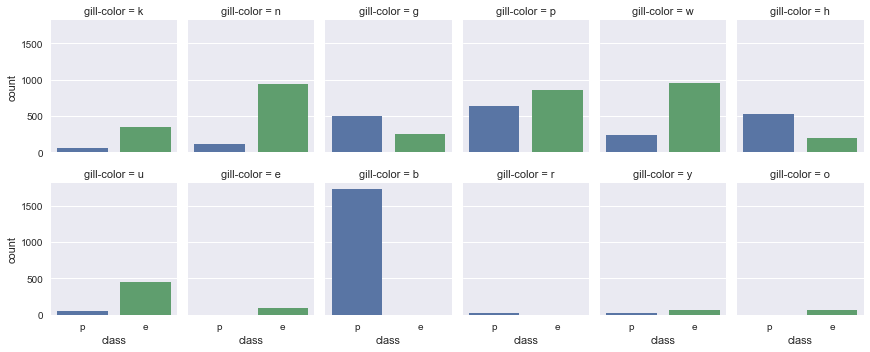

In [37]:
g = sns.factorplot("class", col="gill-color", data=df_forplot,
                    kind="count", size=2.5, aspect=.8, col_wrap=6)

### 1.3 Split data

In [23]:
X = data.iloc[:, 1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

## 2 Classifier

Implementation from [Naive Bayes Classification explained with Python code](http://www.datasciencecentral.com/profiles/blogs/naive-bayes-classification-explained-with-python-code) posted by Ahmet Taspinar on December 15.

In [24]:
class NaiveBaseClass:
    def calculate_relative_occurences(self, list1):
        no_examples = len(list1)
        ro_dict = dict(Counter(list1))
        for key in ro_dict.keys():
            ro_dict[key] = ro_dict[key] / float(no_examples)
        return ro_dict

    def get_max_value_key(self, d1):
        #values = d1.values()
        #keys = d1.keys()
        #max_value_index = values.index(max(values))
        #max_key = keys[max_value_index]
        #return max_key
        max_value = 0
        max_key = -1
        for key, value in d1.items():
            if value > max_value:
                max_value = value
                max_key = key
        return max_key        
        
    def initialize_nb_dict(self):
        self.nb_dict = {}
        for label in self.labels:
            self.nb_dict[label] = defaultdict(list)

class NaiveBayes(NaiveBaseClass):
    """
    Naive Bayes Classifier:
    It is trained with a 2D-array X (dimensions m,n) and a 1D array Y (dimension 1,n).
    X should have one column per feature (total m) and one row per training example (total n).
    After training a dictionary is filled with the class probabilities per feature.
    """
    def train(self, X, Y):
        self.labels = np.unique(Y)
        no_rows, no_cols = np.shape(X)
        self.initialize_nb_dict()
        self.class_probabilities = self.calculate_relative_occurences(Y)
        #fill self.nb_dict with the feature values per class
        for label in self.labels:
            row_indices = np.where(Y == label)[0]
            X_ = X[row_indices, :]
            no_rows_, no_cols_ = np.shape(X_)
            for jj in range(0,no_cols_):
                self.nb_dict[label][jj] += list(X_[:,jj])
        #transform the dict which contains lists with all feature values 
        #to a dict with relative feature value occurences per class
        for label in self.labels:
            for jj in range(0,no_cols):
                self.nb_dict[label][jj] = self.calculate_relative_occurences(self.nb_dict[label][jj])

    def classify_single_elem(self, X_elem):
        Y_dict = {}
        for label in self.labels:
            class_probability = self.class_probabilities[label]
            for ii in range(0,len(X_elem)):
              relative_feature_values = self.nb_dict[label][ii]
              if X_elem[ii] in relative_feature_values.keys():
                class_probability *= relative_feature_values[X_elem[ii]]
              else:
                class_probability *= 0
            Y_dict[label] = class_probability
        return self.get_max_value_key(Y_dict)
                    
    def classify(self, X):
        self.predicted_Y_values = []
        no_rows, no_cols = np.shape(X)
        for ii in range(0,no_rows):
            X_elem = X[ii,:]
            prediction = self.classify_single_elem(X_elem)
            self.predicted_Y_values.append(prediction)
        return self.predicted_Y_values

## 3 Train

In [25]:
nbc = NaiveBayes()
nbc.train(X_train.values, y_train.values)
print("trained")

trained


## 4 Predict

In [26]:
train_predicted_y = nbc.classify(X_train.values)
print("Training accuracy:", metrics.accuracy_score(y_train, train_predicted_y))

test_predicted_y = nbc.classify(X_test.values)
print("Testing accuracy:", metrics.accuracy_score(y_test, test_predicted_y))

Training accuracy: 0.996922603477
Testing accuracy: 0.998153846154
